In [4]:
import pandas as pd

# Load the Reddit data
wsb_data = pd.read_csv('/content/reddit_wsb.csv')

# Display the first few rows of the dataframe to understand its structure and contents
wsb_data.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+09,NaN,2021-01-28 21:26:56


In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Downloading the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores
def calculate_sentiment(text):
    if pd.isna(text):  # Check if text is NaN
        return None
    return sia.polarity_scores(text)['compound']

# Apply the function to the 'title' and 'body' columns to get sentiment scores
# We will fill NaN text with empty strings for calculation
wsb_data['title_sentiment'] = wsb_data['title'].fillna('').apply(calculate_sentiment)
wsb_data['body_sentiment'] = wsb_data['body'].fillna('').apply(calculate_sentiment)

# Filter for posts that mention GameStop in either the title or the body
keyword = 'GameStop'
gamestop_posts = wsb_data[wsb_data['title'].str.contains(keyword, case=False, na=False) |
                          wsb_data['body'].str.contains(keyword, case=False, na=False)]

# Display the filtered dataframe to verify the results
gamestop_posts.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,title,score,id,url,comms_num,created,body,timestamp,title_sentiment,body_sentiment
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+09,NaN,2021-01-28 21:32:10,-0.7034,0.0000
24,Technical Analysis of GameStop ($GME) - TO THE...,324,l6ttk8,https://youtu.be/idbOOXFZnO4/,117.0,1.611860e+09,NaN,2021-01-28 20:48:16,0.0000,0.0000
55,"GameStop, Blackberry, AMC Sees Trade Halts on ...",401,l6skf2,https://www.reddit.com/r/wallstreetbets/commen...,280.0,1.611855e+09,Original Article: [https://www.coinspeaker.com...,2021-01-28 19:21:58,0.0000,0.5935
65,Dillard's the short play no one is talking about,0,l6sc6m,https://www.reddit.com/r/wallstreetbets/commen...,37.0,1.611854e+09,Dillard's has been quietly gaining attention t...,2021-01-28 19:05:39,0.0516,0.7906
72,Before you sleep tonight,550,l6s3d9,https://www.reddit.com/r/wallstreetbets/commen...,147.0,1.611853e+09,Just think about this in simple terms. Everyon...,2021-01-28 18:49:23,0.0000,0.7685


[*********************100%%**********************]  1 of 1 completed


Correlation between daily body sentiment score and GameStop's stock daily return:
                body_sentiment  daily_return
body_sentiment        1.000000     -0.288353
daily_return         -0.288353      1.000000


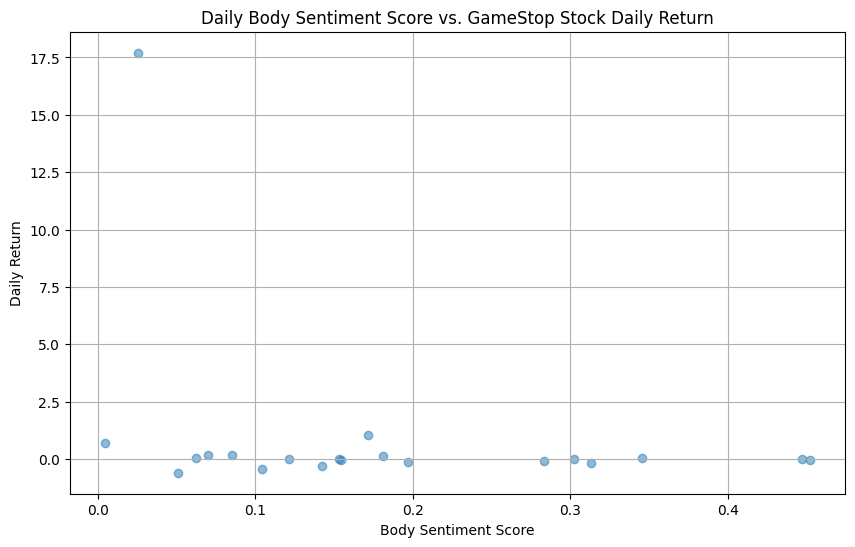

In [9]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# Group by date and calculate the mean body sentiment score for each date
wsb_data['date'] = pd.to_datetime(wsb_data['timestamp']).dt.date
daily_sentiment = wsb_data.groupby('date')['body_sentiment'].mean().reset_index()

# Fetch the GameStop stock price data for the dates in question
gme_data = yf.download('GME', start=daily_sentiment['date'].min(), end=daily_sentiment['date'].max())

# Prepare the GameStop data to merge with sentiment data
gme_data.reset_index(inplace=True)
gme_data['date'] = gme_data['Date'].dt.date

# Merge the daily sentiment data with GameStop's stock price data
merged_data = pd.merge(daily_sentiment, gme_data, on='date')

# Calculate the stock's daily return as a simple measure of stock movement
merged_data['daily_return'] = merged_data['Close'].pct_change()

# Correlate the mean sentiment score with the stock's daily return
correlation = merged_data[['body_sentiment', 'daily_return']].corr()

# Output the correlation result
print("Correlation between daily body sentiment score and GameStop's stock daily return:")
print(correlation)

# Scatter plot for body sentiment scores vs. stock price changes
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['body_sentiment'], merged_data['daily_return'], alpha=0.5)
plt.title('Daily Body Sentiment Score vs. GameStop Stock Daily Return')
plt.xlabel('Body Sentiment Score')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Load data
wsb_data = pd.read_csv('/content/reddit_wsb.csv')

# Convert 'timestamp' to datetime and set as index
wsb_data['date'] = pd.to_datetime(wsb_data['timestamp'])
wsb_data.set_index('date', inplace=True)

# Combine 'title' and 'body' into 'text', handling missing values
wsb_data['text'] = wsb_data['title'] + ' ' + wsb_data['body'].fillna('')

# Sentiment analysis setup
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
wsb_data['sentiment_score'] = wsb_data['text'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Resample sentiment scores by day and calculate the mean
daily_sentiment = wsb_data['sentiment_score'].resample('D').mean().dropna()

# Print the dates with available sentiment scores
print("Dates with available sentiment scores:")
print(daily_sentiment.index)

# Print summary of sentiment scores by day
print("\nSummary of sentiment scores by day (mean):")
print(daily_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dates with available sentiment scores:
DatetimeIndex(['2020-09-29', '2021-01-28', '2021-01-29', '2021-01-30',
               '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05',
               ...
               '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10',
               '2021-08-11', '2021-08-12', '2021-08-13', '2021-08-14',
               '2021-08-15', '2021-08-16'],
              dtype='datetime64[ns]', name='date', length=177, freq=None)

Summary of sentiment scores by day (mean):
date
2020-09-29    0.912700
2021-01-28    0.023345
2021-01-29   -0.008826
2021-01-30    0.152962
2021-01-31    0.163455
                ...   
2021-08-12    0.377009
2021-08-13    0.295266
2021-08-14    0.275024
2021-08-15    0.628829
2021-08-16    0.717727
Name: sentiment_score, Length: 177, dtype: float64


In [ ]:
import yfinance as yf

# Fetch GameStop stock data for the same period
ticker_symbol = "GME"
start_date = '2020-09-29'  # Adjusted to match the earliest date with sentiment scores
end_date = '2021-08-16'    # Adjusted to match the latest date with sentiment scores

gme_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Merge the stock price data with the sentiment scores
combined_data = pd.merge(gme_data, daily_sentiment, how='left', left_index=True, right_index=True)

# Display the merged data
print(combined_data.head())

[*********************100%%**********************]  1 of 1 completed

              Open    High     Low   Close  Adj Close    Volume  \
Date                                                              
2020-09-29  2.5000  2.6625  2.4825  2.5875     2.5875  20950400   
2020-09-30  2.5625  2.6900  2.5150  2.5500     2.5500  24316000   
2020-10-01  2.5225  2.5625  2.4225  2.4425     2.4425  18216400   
2020-10-02  2.3450  2.4450  2.3250  2.3475     2.3475  17362000   
2020-10-05  2.3600  2.3975  2.3125  2.3650     2.3650  11220000   

            sentiment_score  
Date                         
2020-09-29           0.9127  
2020-09-30              NaN  
2020-10-01              NaN  
2020-10-02              NaN  
2020-10-05              NaN  


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch GameStop stock data and the previously calculated sentiment scores
combined_data.dropna(subset=['sentiment_score'], inplace=True)  # Drop days without sentiment data

# Shift stock prices to align with the sentiment score from the previous day
combined_data['next_day_close'] = combined_data['Close'].shift(-1)

# Remove the last row which now contains a NaN in 'next_day_close'
combined_data.dropna(subset=['next_day_close'], inplace=True)

In [ ]:
# Calculate the correlation between sentiment scores and next day's closing prices
correlation = combined_data[['sentiment_score', 'next_day_close']].corr()
print("Correlation between sentiment score and next day's closing stock price:")
print(correlation)

Correlation between sentiment score and next day's closing stock price:
                 sentiment_score  next_day_close
sentiment_score         1.000000        0.148902
next_day_close          0.148902        1.000000


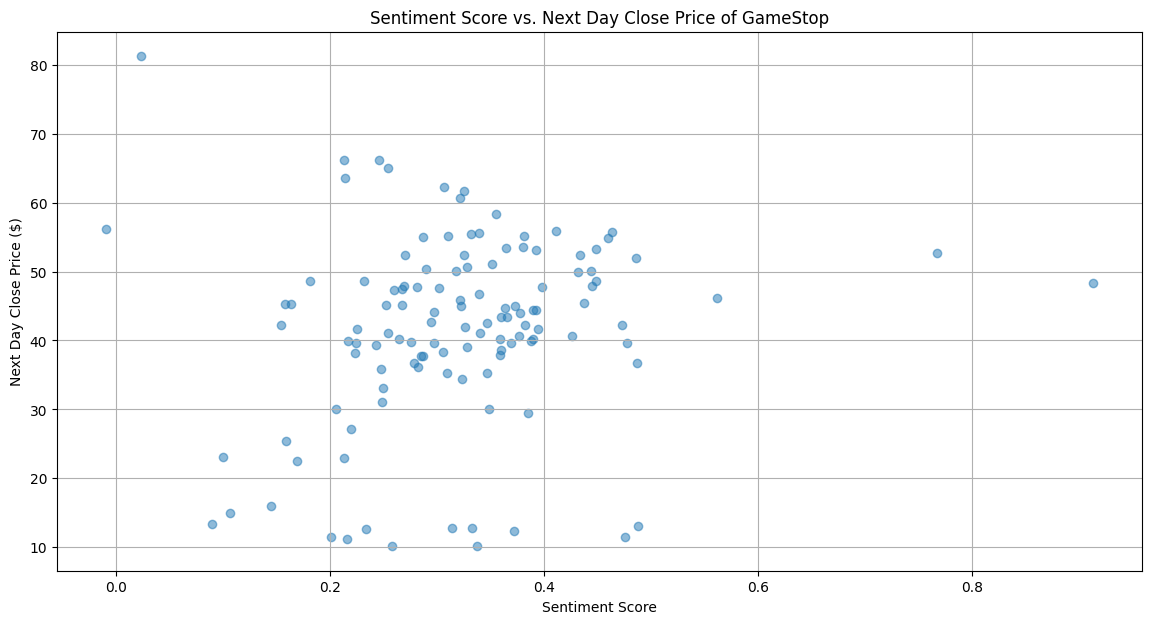

In [ ]:
# Plotting sentiment scores against next day's stock prices
plt.figure(figsize=(14, 7))
plt.scatter(combined_data['sentiment_score'], combined_data['next_day_close'], alpha=0.5)
plt.title('Sentiment Score vs. Next Day Close Price of GameStop')
plt.xlabel('Sentiment Score')
plt.ylabel('Next Day Close Price ($)')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Assuming 'combined_data' is already in the environment and properly formatted
X = combined_data[['sentiment_score']]
y = combined_data['next_day_close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first normalizes the data then applies linear regression
pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 126.70354214769155


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a pipeline with standard scaler and random forest regressor
pipeline_rf = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))

# Train the model
pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error for Random Forest:", mse_rf)

Mean Squared Error for Random Forest: 264.2020820955808


In [ ]:
# Create lag features for sentiment score
for lag in range(1, 4):  # You can change the range for more or fewer lags
    combined_data[f'sentiment_score_lag{lag}'] = combined_data['sentiment_score'].shift(lag)

# Remove rows with NaN values after shifting
combined_data.dropna(inplace=True)

# Redefine X and y with the new features
X = combined_data[[f'sentiment_score_lag{lag}' for lag in range(1, 4)]]
y = combined_data['next_day_close']

# Redefine train and test sets with the new dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a new linear regression model with the lag features
pipeline_lag = make_pipeline(StandardScaler(), LinearRegression())
pipeline_lag.fit(X_train, y_train)

# Predict and evaluate again
y_pred_lag = pipeline_lag.predict(X_test)
mse_lag = mean_squared_error(y_test, y_pred_lag)
print("Mean Squared Error with Lag Features:", mse_lag)

Mean Squared Error with Lag Features: 200.5572110187978


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters to tune
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 150],
    'randomforestregressor__max_depth': [None, 5, 10],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Execute the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Predict with the best estimator
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)

# Calculate MSE with the best estimator
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
print("Mean Squared Error with Best Random Forest:", mse_best_rf)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__n_estimators': 50}
Mean Squared Error with Best Random Forest: 169.93823343835672


In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the Reddit dataset
wsb_data_pg = pd.read_csv('reddit_wsb.csv')

# Filter posts that mention Procter & Gamble in the title or body
wsb_data_pg = wsb_data_pg[
    wsb_data_pg['title'].str.contains('Procter & Gamble|PG|Procter and Gamble|P&G|P & G', na=False, case=False) |
    wsb_data_pg['body'].str.contains('Procter & Gamble|PG|Procter and Gamble|P&G|P & G', na=False, case=False)
]

# Prepare sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Combine title and body into one text column, handling missing values
wsb_data_pg['text'] = wsb_data_pg['title'] + ' ' + wsb_data_pg['body'].fillna('')

# Apply sentiment analysis to get the sentiment score
wsb_data_pg['sentiment_score'] = wsb_data_pg['text'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Group by date and calculate average sentiment score
wsb_data_pg['date'] = pd.to_datetime(wsb_data_pg['timestamp']).dt.date
daily_sentiment_pg = wsb_data_pg.groupby('date')['sentiment_score'].mean().reset_index()

# Fetch Procter & Gamble stock data from yfinance
pg_stock_data = yf.download('PG', start=min(daily_sentiment_pg['date']), end=max(daily_sentiment_pg['date']) + pd.Timedelta(days=1))

# Merge the sentiment data with Procter & Gamble stock price data
pg_stock_data.reset_index(inplace=True)
pg_stock_data['date'] = pg_stock_data['Date'].dt.date
combined_data_pg = pd.merge(pg_stock_data, daily_sentiment_pg, on='date', how='left')

# Align the next day's closing price with the current day's sentiment
combined_data_pg['next_day_close'] = combined_data_pg['Close'].shift(-1)
combined_data_pg.dropna(subset=['next_day_close', 'sentiment_score'], inplace=True)

# Prepare the data for Linear Regression
X_pg = combined_data_pg[['sentiment_score']]
y_pg = combined_data_pg['next_day_close']

# Split the data into training and testing sets
X_train_pg, X_test_pg, y_train_pg, y_test_pg = train_test_split(X_pg, y_pg, test_size=0.2, random_state=42)

# Train a Linear Regression model
lr_model_pg = LinearRegression()
lr_model_pg.fit(X_train_pg, y_train_pg)

# Predict on the test set
y_pred_pg = lr_model_pg.predict(X_test_pg)

# Evaluate the model
mse_pg = mean_squared_error(y_test_pg, y_pred_pg)
print("Mean Squared Error for Procter & Gamble stock predictions:", mse_pg)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%%**********************]  1 of 1 completed

Mean Squared Error for Procter & Gamble stock predictions: 23.0192427104834


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the Reddit dataset
reddit_data = pd.read_csv('reddit_wsb.csv')

# Filter posts that mention Berkshire Hathaway in the title or body
regex_berkshire = 'Berkshire Hathaway|Berkshire|BRK|Warren Buffett'
reddit_data_berkshire = reddit_data[
    reddit_data['title'].str.contains(regex_berkshire, na=False, case=False) |
    reddit_data['body'].str.contains(regex_berkshire, na=False, case=False)
]

# Prepare sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Combine title and body into one text column, handling missing values
reddit_data_berkshire['text'] = reddit_data_berkshire['title'] + ' ' + reddit_data_berkshire['body'].fillna('')

# Apply sentiment analysis to get the sentiment score
reddit_data_berkshire['sentiment_score'] = reddit_data_berkshire['text'].apply(
    lambda text: sia.polarity_scores(text)['compound']
)

# Group by date and calculate average sentiment score
reddit_data_berkshire['date'] = pd.to_datetime(reddit_data_berkshire['timestamp']).dt.date
daily_sentiment_berkshire = reddit_data_berkshire.groupby('date')['sentiment_score'].mean().reset_index()

# Fetch Berkshire Hathaway stock data from yfinance
brk_stock_data = yf.download('BRK-B', start=min(daily_sentiment_berkshire['date']), end=max(daily_sentiment_berkshire['date']) + pd.Timedelta(days=1))

# Merge the sentiment data with Berkshire Hathaway stock price data
brk_stock_data.reset_index(inplace=True)
brk_stock_data['date'] = brk_stock_data['Date'].dt.date
combined_data_berkshire = pd.merge(brk_stock_data, daily_sentiment_berkshire, on='date', how='left')

# Align the next day's closing price with the current day's sentiment
combined_data_berkshire['next_day_close'] = combined_data_berkshire['Close'].shift(-1)
combined_data_berkshire.dropna(subset=['next_day_close', 'sentiment_score'], inplace=True)

# Prepare the data for Linear Regression
X_berkshire = combined_data_berkshire[['sentiment_score']]
y_berkshire = combined_data_berkshire['next_day_close']

# Split the data into training and testing sets
X_train_berkshire, X_test_berkshire, y_train_berkshire, y_test_berkshire = train_test_split(
    X_berkshire, y_berkshire, test_size=0.2, random_state=42
)

# Train a Linear Regression model
lr_model_berkshire = LinearRegression()
lr_model_berkshire.fit(X_train_berkshire, y_train_berkshire)

# Predict on the test set
y_pred_berkshire = lr_model_berkshire.predict(X_test_berkshire)

# Evaluate the model
mse_berkshire = mean_squared_error(y_test_berkshire, y_pred_berkshire)
print("Mean Squared Error for Berkshire Hathaway stock predictions:", mse_berkshire)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-2-ec645e82a3cc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data_berkshire['text'] = reddit_data_berkshire['title'] + ' ' + reddit_data_berkshire['body'].fillna('')
<ipython-input-2-ec645e82a3cc>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data_berkshire['sentiment_score'] = reddit_data_berkshire['text'].apply(
<ipython-input-2-ec645e82a3cc>:32: SettingWithCopyWarning: 
A value is trying to be set on

Mean Squared Error for Berkshire Hathaway stock predictions: 407.10848168131116
